In [83]:
import io
import os

import boto3
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
client = boto3.client(
    's3',
    aws_access_key_id = 'sukiK@2002',
    aws_secret_access_key = 'sukik',
    region_name = 'ap-west-1'
)

In [3]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

In [4]:
files = ['amazon_reviews_us_Electronics_v1_00.tsv', \
         'amazon_reviews_us_Gift_Card_v1_00.tsv', \
         'amazon_reviews_us_Major_Appliances_v1_00.tsv', \
         'amazon_reviews_us_Office_Products_v1_00.tsv', \
         'amazon_reviews_us_Shoes_v1_00.tsv', \
         'amazon_reviews_us_Toys_v1_00.tsv', \
         'amazon_reviews_us_Watches_v1_00.tsv']

In [5]:
columns = ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']
len(columns)

15

In [6]:
bucket = 'farsdata'
prefix = 'dataFiles'
data_location = 's3://{}/{}/'.format(bucket, prefix)
data_location

's3://farsdata/dataFiles/'

one_file = pd.read_csv(data_location + files[0], names = columns, sep = '\t').iloc[1:,:]
one_file.head()

In [59]:
#test.rename(columns=test.iloc[0])
training_data = pd.DataFrame() #initialize an empty dataframe
testing_data = pd.DataFrame()

one_file = pd.read_csv(data_location + files[1], names = columns, sep = '\t').iloc[1:,:]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1,4,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [60]:
one_file.shape

(148310, 15)

In [51]:
def convert_to_int(x):
    return int(float(x))

In [62]:
#convert all mixed datatypes --> string objects (unable to convert to int)
one_file['customer_id'] = one_file['customer_id'].apply(int) #1
one_file['product_parent'] = one_file['product_parent'].apply(int) #4
one_file['star_rating'] = one_file['star_rating'].apply(int) #7
one_file['helpful_votes'] = one_file['helpful_votes'].apply(int) #8
one_file['total_votes'] = one_file['total_votes'].apply(int) #9

In [64]:
one_file.isnull().sum().sort_values(ascending=False)

review_headline      3
review_body          2
review_date          1
verified_purchase    0
vine                 0
total_votes          0
helpful_votes        0
star_rating          0
product_category     0
product_title        0
product_parent       0
product_id           0
review_id            0
customer_id          0
marketplace          0
dtype: int64

In [65]:
one_file.dropna(inplace=True) #drop all of the missing values
one_file.isnull().sum().sort_values(ascending=False)

review_date          0
review_body          0
review_headline      0
verified_purchase    0
vine                 0
total_votes          0
helpful_votes        0
star_rating          0
product_category     0
product_title        0
product_parent       0
product_id           0
review_id            0
customer_id          0
marketplace          0
dtype: int64

for i in range(0, 3):
    print(i)
    model_data = pd.read_csv(data_location + files[i], names = columns, sep = '\t')
    
    train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
    print(train_data.shape, test_data.shape)
    
    training_data.append(train_data, ignore_index=True)
    testing_data.append(test_data, ignore_index=True)

In [67]:
#there may be tabs in the review that is what is leading to the excluded cases when converting to df

'''
train_data['verified_purchase'].value_counts()
test_data['verified_purchase'].value_counts()
'''

one_file.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
110345,US,49502089,RPSGG0QUKP70G,B004LLIKVU,473048287,Amazon.com eGift Cards,Gift Card,4,0,0,N,Y,Easy Gift,Needed a quick gift for a grandson. The young ...,2013-04-09
138041,US,17693547,R1JXVDG7WE7L05,BT00CTOUNS,775486538,Amazon.com Gift Card in a Greeting Card (Vario...,Gift Card,5,0,0,N,N,Loved it!,I loved my amazon gift card.... it's the easie...,2012-01-27
146761,US,19514665,R29VCPMUU37HSS,BT00CTP8P2,957074141,Amazon.com $25 Gift Card in a Greeting Card (A...,Gift Card,5,0,0,N,Y,gift card,card was delivered promptly and the person who...,2010-12-31
93754,US,35799750,R3MHA17PWQOQAP,B005J02O00,775486538,Amazon.com Gift Card in a Greeting Card (Vario...,Gift Card,1,0,1,N,Y,Holiday message not included but it was on my ...,Did not come with my holiday message printed o...,2013-11-27
92767,US,46898077,R3SI19YSNBDNYJ,B0091JKY0M,941945933,Amazon.com Gift Card for Any Amount in a Santa...,Gift Card,5,0,0,N,Y,A really cute tin!,Love this cute tin for our Amazon gift card. I...,2013-12-13


#to check te datatypes within each column

print(train_data.applymap(type))
data_types = train_data.applymap(type)

In [68]:
#the number of customers that gave multiple reviews
#may be valueable to investigate
one_file.groupby('customer_id').count()['marketplace'].sort_values(ascending = False).value_counts()

1    98149
2     2561
3      156
4       12
5        5
Name: marketplace, dtype: int64

In [69]:
one_file['star_rating'].value_counts()

5    90346
4     6849
1     3290
3     2197
2     1130
Name: star_rating, dtype: int64

### Sentiment Analysis

In [78]:
#df is all data other than rating 3
df = one_file[one_file['star_rating'] != 3]

In [79]:
df['star_rating'].value_counts()

5    90346
4     6849
1     3290
2     1130
Name: star_rating, dtype: int64

In [80]:
df['positively_rated'] = np.where(df['star_rating'] > 3, 1, 0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [81]:
df['positively_rated'].value_counts()

1    97195
0     4420
Name: positively_rated, dtype: int64

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='positively_rated', ylabel='count'>

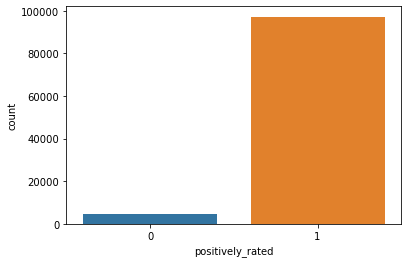

In [84]:
sns.countplot(df['positively_rated'])

In [85]:
train_data, test_data = np.split(one_file.sample(frac=1, random_state=1729), [int(0.7 * len(one_file))])
print(train_data.shape, test_data.shape)

(103812, 15) (44492, 15)


In [101]:
X_train = train_data['review_body']
X_train.iloc[0] #to_frame()

'Needed a quick gift for a grandson. The young kids love this kind of gift, they can choose what they want.'

In [108]:
Y_train = train_data['star_rating']

In [111]:
X_test = test_data['review_body']
Y_test = test_data['star_rating']

#### TF-IDF - to get predictions of what star rating will be based on text of review

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [105]:
vect = TfidfVectorizer().fit(X_train)

In [106]:
len(vect.get_feature_names()) #unique words

26090

In [107]:
X_train_vect = vect.transform(X_train)

In [110]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_vect, Y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [112]:
predictions = model.predict(vect.transform(X_test))

In [125]:
roc = {label: [] for label in Y_train.unique()}
for label in Y_train.unique():
    vect = TfidfVectorizer().fit(X_train)
    predictions_proba = vect.predict(X_test)
    roc[label] += roc_auc_score(label, predictions_proba[:,1])

AttributeError: 'TfidfVectorizer' object has no attribute 'predict_proba'

In [122]:
len(predictions)

44492

In [127]:
def plot_confusion_matrix(cm, target_names,
                          fname, epoch,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True, target=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    plt.style.use('default')

    # # only true if it weren't normalized:
    # accuracy = np.trace(cm) / float(np.sum(cm))
    # misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm[np.isnan(cm)] = 0.0

    fig = plt.figure(figsize=(5, 4))
    ax = plt.axes()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    if target == "rule-based":
        plt.title(title + ' for rule-based PF')
    else:
        plt.title(title + ' for MLPF at epoch ' + str(epoch))

    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlim(-1, len(target_names))
    plt.ylim(-1, len(target_names))
    plt.xlabel('Predicted label')
    # plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()
    plt.savefig(fname + '.png')
    plt.savefig(fname + '.pdf')
    #plt.close(fig)

    return fig, ax

In [128]:
import sklearn

In [131]:
cn = sklearn.metrics.confusion_matrix(Y_test, predictions, labels=None, sample_weight=None, normalize=None)

(<Figure size 500x400 with 2 Axes>,
 <AxesSubplot:title={'center':'0 for MLPF at epoch ConfusionMatrix.png'}, xlabel='Predicted label', ylabel='True label'>)

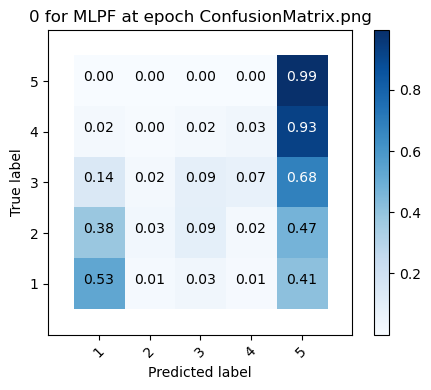

In [132]:
plot_confusion_matrix(cn, [1, 2, 3, 4, 5], "ConfusionMatrixTest", "ConfusionMatrix.png", "0")
#problem where all of the ratings are being predicted as 5

In [134]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()

In [143]:
feature_names[22935]

'terrible'

In [147]:
list(map(lambda x: feature_names[x], sorted_coef_index[:-11:-1]))

['never',
 'not',
 'terrible',
 'tried',
 'waste',
 'charged',
 'unable',
 'horrible',
 'won',
 'poor']

In [146]:
print("smallest coef", list(map(lambda x: feature_names[x], sorted_coef_index[:10])))

smalalest coef ['easy', 'great', 'love', 'perfect', 'loved', 'sure', 'like', 'quick', 'convenient', 'nice']


In [148]:
print("largest coef", list(map(lambda x: feature_names[x], sorted_coef_index[:-11:-1])))

largest coef ['never', 'not', 'terrible', 'tried', 'waste', 'charged', 'unable', 'horrible', 'won', 'poor']
